## **1. 환경 구축 및 설정**

- 데이터 업로드

In [1]:
import gdown
import os

In [ ]:
train_image_id = '1c_ewb8Zxr7DeH1z1696BF3p7MQPLes5F'
gdown.download(id=train_image_id, output='./cityscapes_mini.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1c_ewb8Zxr7DeH1z1696BF3p7MQPLes5F
From (redirected): https://drive.google.com/uc?id=1c_ewb8Zxr7DeH1z1696BF3p7MQPLes5F&confirm=t&uuid=7aceb8ca-4605-498b-8996-3933631957a4
To: /content/cityspaces_mini.zip
100%|██████████| 209M/209M [00:02<00:00, 89.7MB/s]


0

In [ ]:
os.system("unzip ./cityscapes_mini/cityscapes_mini.zip")

- 필요한 패키지 가져오기

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.9.1+cu128


- 설정 변수

In [ ]:
# 데이터셋 루트 폴더 (Cityscapes Mini Dataset의 root 디렉토리로 변경)
# 예: DATA_ROOT = "/home/skyy/datasets/cityspaces" (여기서는 'cityspaces' 폴더 자체의 경로)
DATA_ROOT = "./cityscapes_mini"

In [5]:
# U-Net 모델의 입력 이미지 크기
INPUT_IMAGE_SIZE = 256 # Cityscapes 이미지 크기 (보통 1024x2048)를 256으로 리사이즈

# Cityscapes Dataset의 클래스 및 ID 정의 (19개 클래스)
NUM_CLASSES = 19 # (0~18) - 255는 ignore_index로 처리

# Cityscapes ID to Train ID 매핑 (Cityscapes 공식 스크립트 기반)
cityscapes_id_to_trainid = {
    0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,
    7: 0, 8: 1, 9: 255, 10: 255, 11: 2, 12: 3, 13: 4, 14: 255,
    15: 255, 16: 255, 17: 5, 18: 255, 19: 6, 20: 7, 21: 8, 22: 9,
    23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 29: 255, 30: 255,
    31: 16, 32: 17, 33: 18, -1: 255 # -1은 공식적으로 맵핑되지 않는 ID (예: license plate)
}

# Cityscapes Color Palette (Visualization)
CITYSCAPES_PALETTE = {
    0: [128, 64, 128],    # road
    1: [244, 35, 232],    # sidewalk
    2: [70, 70, 70],      # building
    3: [102, 102, 156],   # wall
    4: [190, 153, 153],   # fence
    5: [153, 153, 153],   # pole
    6: [250, 170, 30],    # traffic light
    7: [220, 220, 0],     # traffic sign
    8: [107, 142, 35],    # vegetation
    9: [152, 251, 152],   # terrain
    10: [70, 130, 180],   # sky
    11: [220, 20, 60],    # person
    12: [255, 0, 0],      # rider
    13: [0, 0, 142],      # car
    14: [0, 0, 70],       # truck
    15: [0, 60, 100],     # bus
    16: [0, 80, 100],     # train
    17: [0, 0, 230],      # motorcycle
    18: [119, 11, 32],    # bicycle
    255: [0, 0, 0]        # ignore (black)
}

- GPU 설정

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **2. U-Net 모델 정의**

- Convolutional Block

In [7]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

- Encoder Block

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = conv_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2) # 2x2 Max Pooling

    def forward(self, x):
        conv_out = self.conv(x) # conv_block을 먼저 적용
        pooled_out = self.pool(conv_out) # conv_block의 출력에 Max Pooling 적용
        return conv_out, pooled_out # Conv 출력과 Pool 출력을 모두 반환

- Decoder Block

In [9]:
class Decoder(nn.Module):
    def __init__(self, in_channels_dec_up, in_channels_skip, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # 컨볼루션 블록의 입력 채널은 업샘플링된 특징과 스킵 커넥션 특징을 합친 것
        self.conv = conv_block(in_channels_dec_up + in_channels_skip, out_channels)

    def forward(self, x, skip_connection_feature):
        x = self.up(x) # 업샘플링

        # 스킵 커넥션 특징과 채널 차원으로 합치기
        # 이 때 x와 skip_connection_feature의 공간 해상도가 정확히 일치해야 합니다.
        if x.shape[2:] != skip_connection_feature.shape[2:]:
            skip_connection_feature = F.interpolate(skip_connection_feature, size=x.shape[2:], mode='bilinear', align_corners=True)

        x = torch.cat([x, skip_connection_feature], dim=1)
        x = self.conv(x) # <--- 이 부분의 self.conv(x)
        return x

- U-Net Architecture

In [10]:
class UNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        # Encoder Path
        self.enc1 = Encoder(3, 64)
        self.enc2 = Encoder(64, 128)
        self.enc3 = Encoder(128, 256)
        self.enc4 = Encoder(256, 512)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder Path
        # in_channels_dec_up, in_channels_skip, out_channels 순서
        self.dec4 = Decoder(1024, 512, 512) # (bottleneck 출력 1024 -> upsample -> 1024채널) + (e4_conv 512채널) -> 512 출력
        self.dec3 = Decoder(512, 256, 256) # (d4 출력 512 -> upsample -> 512채널) + (e3_conv 256채널) -> 256 출력
        self.dec2 = Decoder(256, 128, 128) # (d3 출력 256 -> upsample -> 256채널) + (e2_conv 128채널) -> 128 출력
        self.dec1 = Decoder(128, 64, 64)   # (d2 출력 128 -> upsample -> 128채널) + (e1_conv 64채널) -> 64 출력

        # Output Layer
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1_conv, e1_pool = self.enc1(x)  # e1_conv는 skip connection용
        e2_conv, e2_pool = self.enc2(e1_pool)
        e3_conv, e3_pool = self.enc3(e2_pool)
        e4_conv, e4_pool = self.enc4(e3_pool)

        # Bottleneck
        bottleneck = self.bottleneck(e4_pool)

        # Decoder (eX_conv와 concat)
        d4 = self.dec4(bottleneck, e4_conv)
        d3 = self.dec3(d4, e3_conv)
        d2 = self.dec2(d3, e2_conv)
        d1 = self.dec1(d2, e1_conv)

        # Output
        return self.output_conv(d1)

## **3. 데이터셋 로드 및 전처리**

- Cityscapes Mini Dataset 로더

In [11]:
class CityscapesMiniDataset(Dataset):
    def __init__(self, root_dir, split='train', transform_img=None, transform_mask=None, id_to_trainid_map=None):
        self.root_dir = root_dir
        self.split = split
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.id_to_trainid_map = id_to_trainid_map if id_to_trainid_map is not None else {}

        self.image_paths = []
        self.mask_paths = []

        # 스카이님의 새로운 디렉토리 구조에 맞춤
        img_dir = os.path.join(self.root_dir, self.split, 'img')
        label_dir = os.path.join(self.root_dir, self.split, 'label')

        if not os.path.exists(img_dir):
            raise FileNotFoundError(f"Image directory not found: {img_dir}")
        if not os.path.exists(label_dir):
            raise FileNotFoundError(f"Label directory not found: {label_dir}")

        # 이미지 파일 목록을 가져와서 마스크 파일과 매칭
        for img_filename in os.listdir(img_dir):
            if img_filename.endswith('.png') or img_filename.endswith('.jpg'): # jpg도 처리 가능하도록
                img_path = os.path.join(img_dir, img_filename)

                # 마스크 파일 이름이 이미지 파일 이름과 동일하고 .png 확장자를 가진다고 가정
                mask_filename = img_filename # .png 확장자일 것이므로 그대로 사용
                mask_path = os.path.join(label_dir, mask_filename)

                if os.path.exists(mask_path): # 마스크 파일이 있는지 확인
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)
                # else:
                #     print(f"Warning: Corresponding mask not found for {img_filename} at {mask_path}")

        print(f"Loaded {len(self.image_paths)} images for {self.split} split from Cityscapes Mini Dataset with custom structure.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') # Label ID 마스크는 단일 채널 (Grayscale)

        mask_np = np.array(mask, dtype=np.uint8)

        # Cityscapes trainId 매핑 (클래스 ID에 따라 정의된 매핑 사용)
        mapped_mask = np.full(mask_np.shape, 255, dtype=np.uint8) # 255로 초기화 (ignore)

        for original_id, train_id in self.id_to_trainid_map.items():
            mapped_mask[mask_np == original_id] = train_id

        mask = Image.fromarray(mapped_mask)

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        else:
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))

        return image, mask

- 이미지 전처리: 리사이즈, 텐서 변환, 정규화

In [12]:
transform_img = transforms.Compose([
    transforms.Resize((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)),
    transforms.ToTensor(), # HWC to CWH, [0, 255] to [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet 통계
])

- 마스크 전처리: 리사이즈, 텐서 변환 (클래스 ID이므로 정규화 없음)

In [13]:
class ConvertMaskToTensor:
    def __call__(self, mask_pil):
        # PIL Image를 NumPy 배열로 변환하고 int64 타입으로 지정
        mask_np = np.array(mask_pil, dtype=np.int64)
        # NumPy 배열을 torch.LongTensor로 변환 (스케일링 없음)
        return torch.from_numpy(mask_np)

transform_mask = transforms.Compose([
    transforms.Resize((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE), interpolation=Image.NEAREST), # 마스크는 Nearest Neighbor 보간 필수
    ConvertMaskToTensor() # 사용자 정의 변환 적용
])

- DataLoader 생성

In [14]:
train_dataset = CityscapesMiniDataset(root_dir=DATA_ROOT, split='train',
                                      transform_img=transform_img, transform_mask=transform_mask,
                                      id_to_trainid_map=cityscapes_id_to_trainid)
val_dataset = CityscapesMiniDataset(root_dir=DATA_ROOT, split='val',
                                    transform_img=transform_img, transform_mask=transform_mask,
                                    id_to_trainid_map=cityscapes_id_to_trainid)

print(f"훈련 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

Loaded 2975 images for train split from Cityscapes Mini Dataset with custom structure.
Loaded 500 images for val split from Cityscapes Mini Dataset with custom structure.
훈련 데이터셋 크기: 2975
검증 데이터셋 크기: 500


## **4. 학습 함수**

In [15]:
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    print("\n--- U-Net 모델 학습 시작 ---")
    print(f"({num_epochs} 에포크 진행, 학습 데이터 {len(train_loader)} 배치)")

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, masks) in enumerate(train_loader):
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / (i+1):.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs_val, masks_val in val_loader:
                inputs_val = inputs_val.to(device)
                masks_val = masks_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, masks_val)
                val_loss += loss_val.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Train Loss: {running_loss / len(train_loader):.4f}, Avg Val Loss: {val_loss / len(val_loader):.4f}")
        model.train()

    print("\n--- U-Net 모델 학습 완료 ---")
    return model

## **5. 추론 및 시각화 함수**

In [16]:
def visualize_segmentation(model, dataset, num_samples=5):
    model.eval()
    print(f"\n--- U-Net 모델 추론 및 시각화 시작 ({num_samples}개 샘플) ---")

    if len(dataset) < num_samples:
        print(f"경고: 데이터셋 크기({len(dataset)}개)가 요청한 샘플 수({num_samples}개)보다 작습니다. 모든 샘플을 시각화합니다.")
        sample_indices = list(range(len(dataset)))
    else:
        sample_indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(20, num_samples * 5))

    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            img_tensor, true_mask_tensor = dataset[idx]

            input_batch = img_tensor.unsqueeze(0).to(device)

            output = model(input_batch)

            predicted_mask = torch.argmax(F.softmax(output, dim=1), dim=1).squeeze(0).cpu().numpy()

            img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = (img_np * std + mean) * 255
            img_np = np.clip(img_np, 0, 255).astype(np.uint8)

            true_mask_np = true_mask_tensor.cpu().numpy()
            true_color_mask = np.zeros((*true_mask_np.shape, 3), dtype=np.uint8)
            for class_id, color in CITYSCAPES_PALETTE.items():
                if class_id == 255:
                    continue
                true_color_mask[true_mask_np == class_id] = color

            predicted_color_mask = np.zeros((*predicted_mask.shape, 3), dtype=np.uint8)
            for class_id, color in CITYSCAPES_PALETTE.items():
                if class_id == 255:
                    continue
                predicted_color_mask[predicted_mask == class_id] = color

            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(img_np)
            plt.title(f"Original Image")
            plt.axis('off')

            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(true_color_mask)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(num_samples, 3, i*3 + 3)
            blended_image = cv2.addWeighted(img_np, 0.7, predicted_color_mask, 0.3, 0)
            plt.imshow(blended_image)
            plt.title("Predicted Overlay")
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("--- 추론 및 시각화 완료 ---")

## **6. 메인 실행 블록**

In [17]:
# 1. 모델 생성 및 디바이스 이동
model = UNet(num_classes=NUM_CLASSES).to(device)

In [18]:
# 2. 모델 학습
# (예시이므로 짧게 5 에포크만 진행. 실제는 더 오래 학습해야 합니다.)
trained_model = train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001)


--- U-Net 모델 학습 시작 ---
(20 에포크 진행, 학습 데이터 744 배치)
Epoch [1/20], Step [50/744], Loss: 3.1383
Epoch [1/20], Step [100/744], Loss: 2.8327
Epoch [1/20], Step [150/744], Loss: 2.6752
Epoch [1/20], Step [200/744], Loss: 2.5680
Epoch [1/20], Step [250/744], Loss: 2.4999
Epoch [1/20], Step [300/744], Loss: 2.4495
Epoch [1/20], Step [350/744], Loss: 2.4191
Epoch [1/20], Step [400/744], Loss: 2.3982
Epoch [1/20], Step [450/744], Loss: 2.3695
Epoch [1/20], Step [500/744], Loss: 2.3573
Epoch [1/20], Step [550/744], Loss: 2.3421
Epoch [1/20], Step [600/744], Loss: 2.3122
Epoch [1/20], Step [650/744], Loss: 2.2858
Epoch [1/20], Step [700/744], Loss: 2.2769
Epoch [1/20] - Avg Train Loss: 2.2660, Avg Val Loss: 2.2440
Epoch [2/20], Step [50/744], Loss: 2.0553
Epoch [2/20], Step [100/744], Loss: 2.1007
Epoch [2/20], Step [150/744], Loss: 2.0789
Epoch [2/20], Step [200/744], Loss: 2.0958
Epoch [2/20], Step [250/744], Loss: 2.0843
Epoch [2/20], Step [300/744], Loss: 2.0805
Epoch [2/20], Step [350/744], L


--- U-Net 모델 추론 및 시각화 시작 (5개 샘플) ---


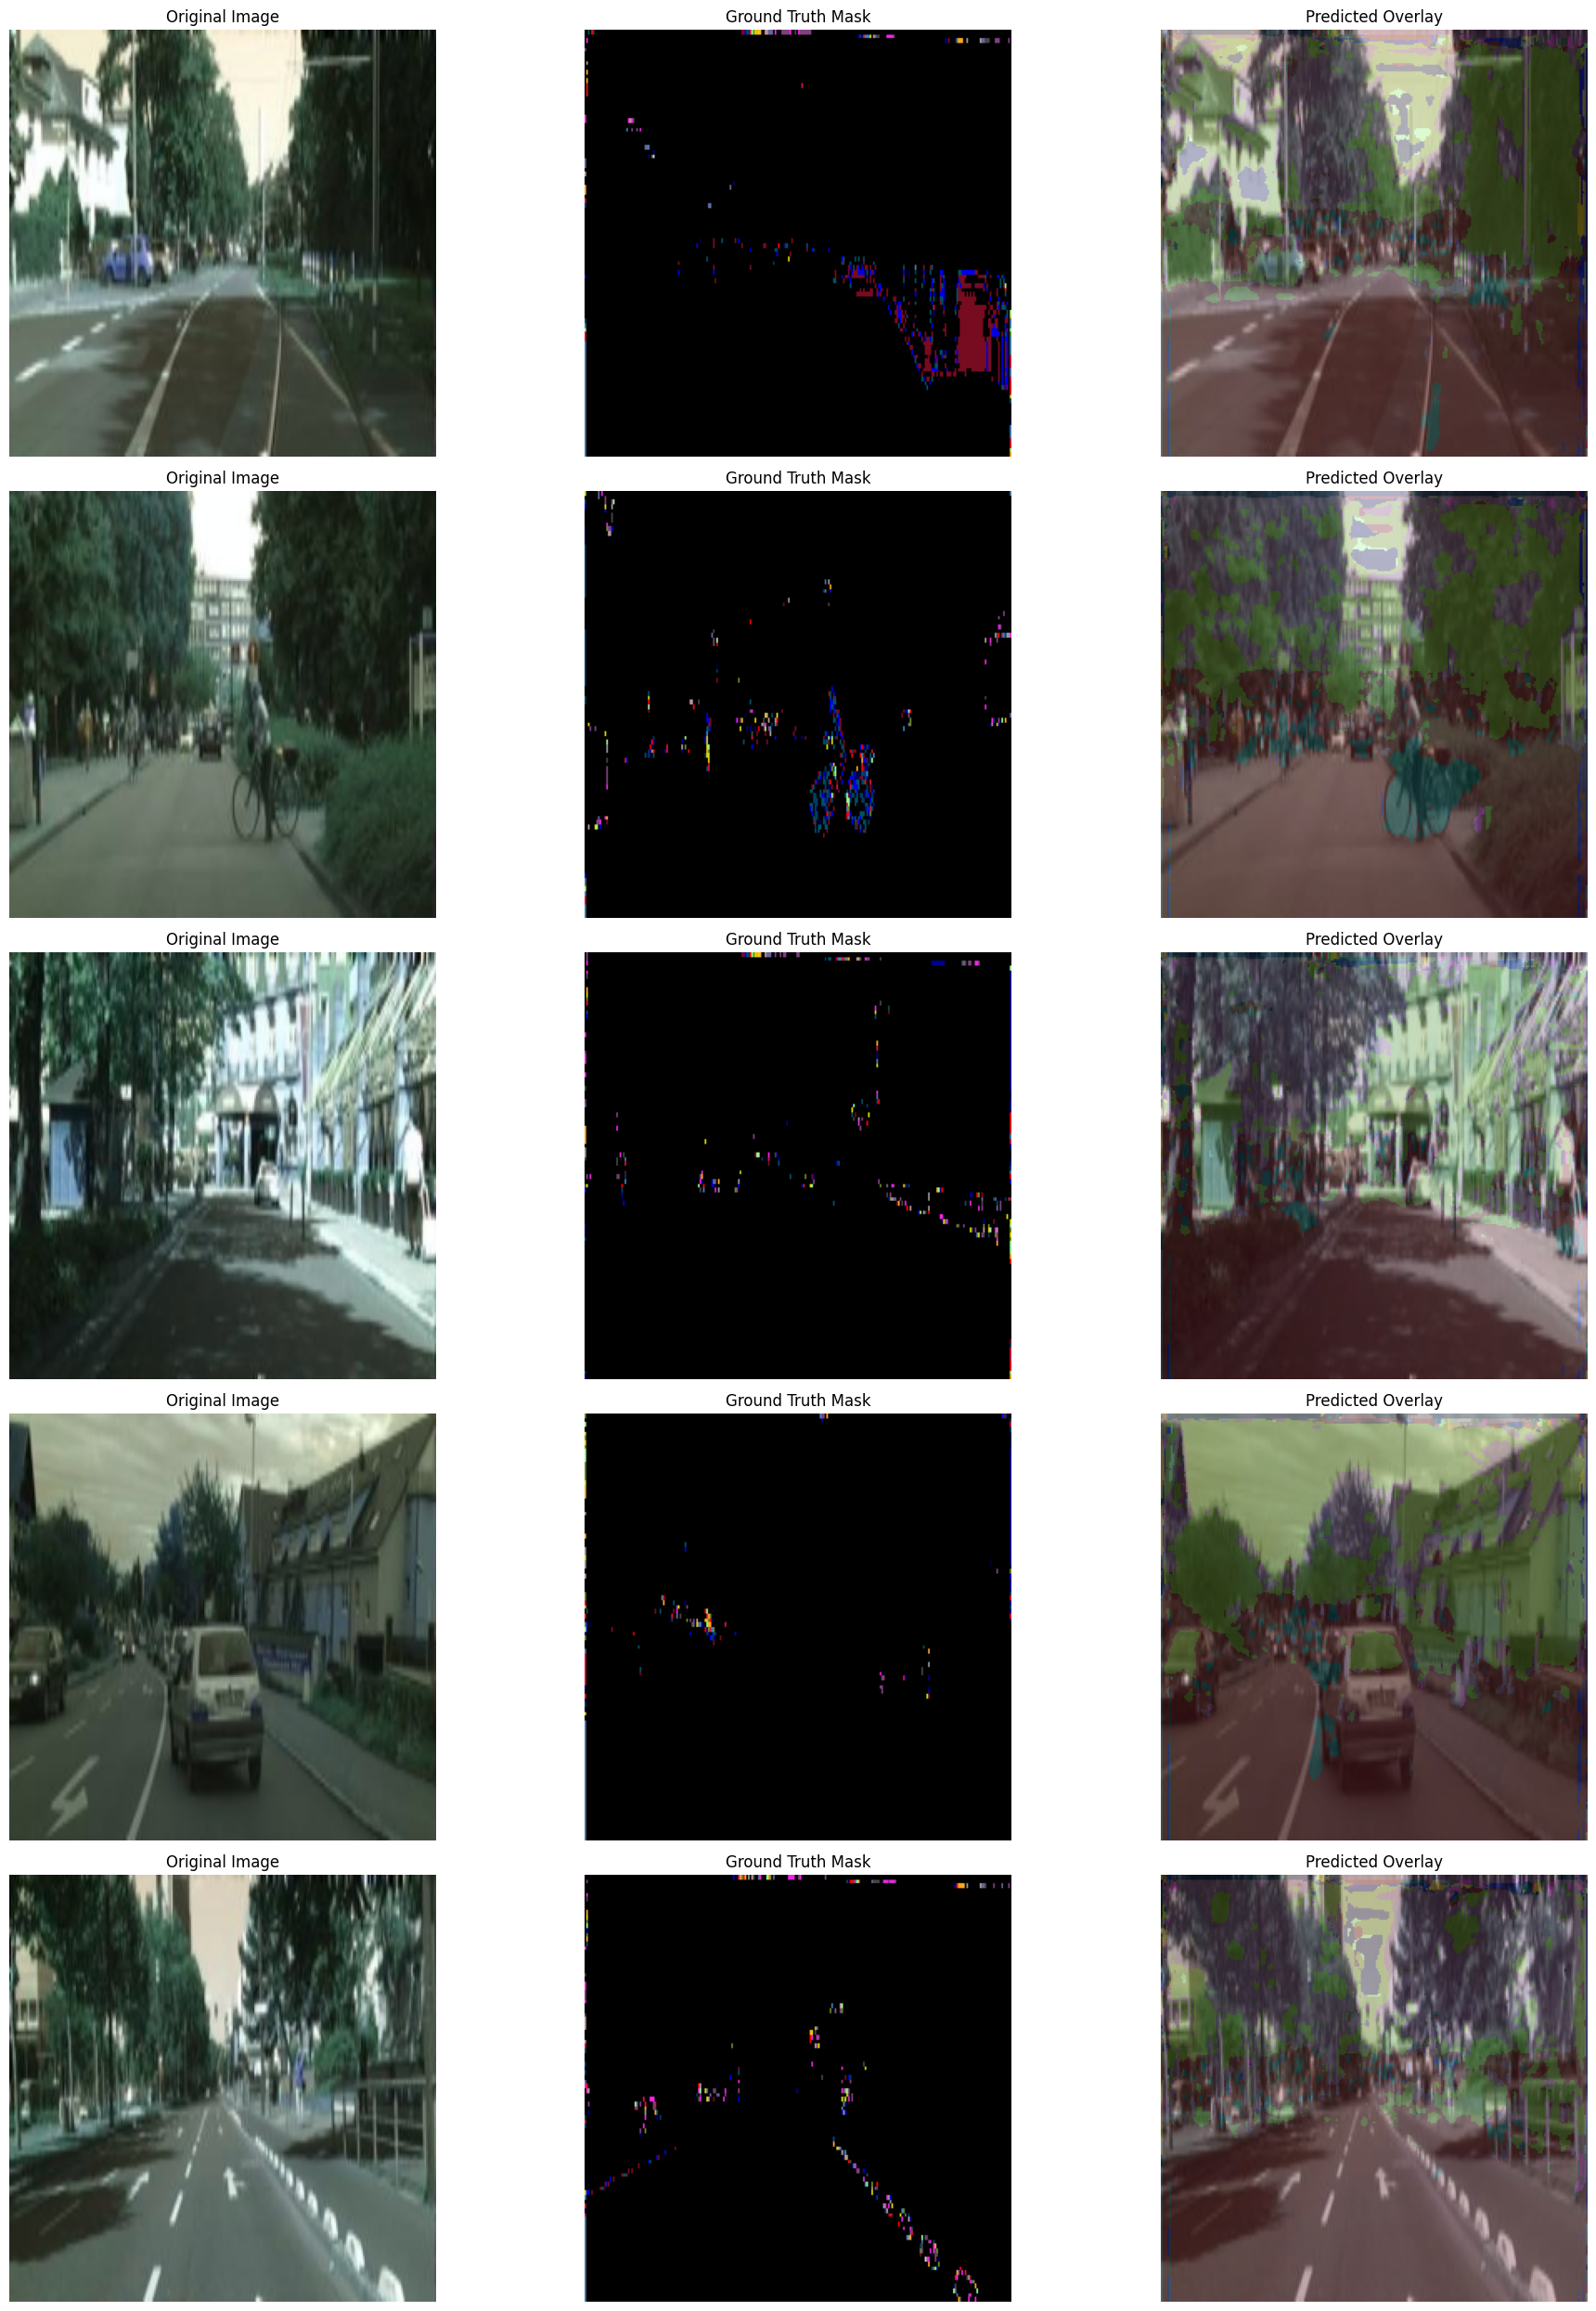

--- 추론 및 시각화 완료 ---


In [19]:
visualize_segmentation(trained_model, val_dataset, num_samples=5)